In [2]:
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *
# from tensorflow.keras.models import load_model

# CoastalWQL
This is the python notebook for the workflow process as follows:

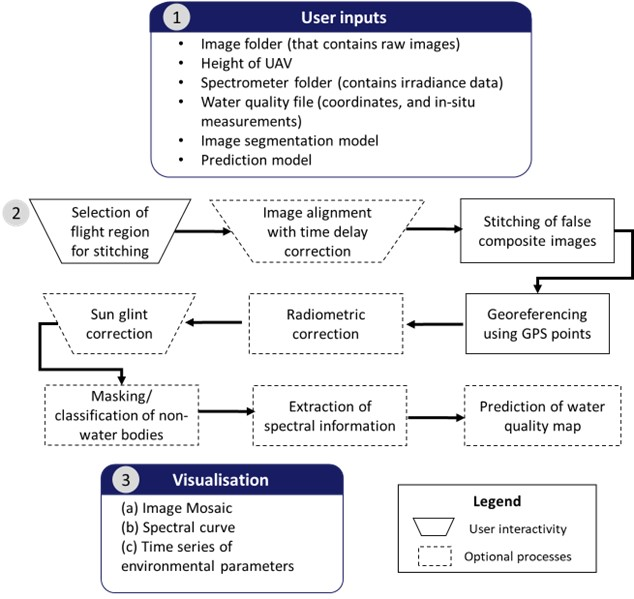

In [3]:
%matplotlib inline
from IPython.display import Image
Image('workflow.jpg')

### Indicate the directory for storing processed images

## Inputs

#### Required inputs

In [4]:
image_fp = r"C:/Users/PAKHUIYING/Documents/image_processing/2022-08-25/13-21-00RES1280_EXP0100_GAN0030_BIT08_2EXP0002_GAN0010_RES1280_BIT08"
spectrometer_fp = r"C:/Users/PAKHUIYING/Documents/image_processing/2022-08-25/08_25_2022"
fp_store = r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2_DNN" #directory to store processed files
prefix = "2022_08_25_13-21-00_DNN"
height = 60 #in meters
gps_index_txt = r"C:/Users/PAKHUIYING/OneDrive - Nanyang Technological University/NTU/image_processing/F3_processed_images/2022_08_25_2/gps_index_2022_08_25_13-21-00.txt"
slider = 1400 #in milliseconds (time delay correction)
mask_checkbox = True
classify_checkbox = False
noise_checkbox = True
sunglint_checkbox = False
radiometric_checkbox = True
corrected_indices = None

tss_lat = tss_lon = tss_measurements = None

corrected_fp = r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2\corrected_indices.json" #corrected image indices (optional)
corrected_indices = None
line_start = 0
line_stop = 1
r,g,b = 38,23,15

with open(gps_index_txt, "r") as f:
    gps_indices = f.readlines()
gps_indices = [int(i.replace('\n','')) for i in gps_indices]
gps_indices.sort()

#------optional (can comment out)--------
with open(corrected_fp, "r") as read_file:
    corrected_indices = json.load(read_file)
corrected_indices = [(i['start'],i['stop']) for i in corrected_indices]


#### Sun glint correction inputs (optional)

In [5]:
sunglint_json_fp = None
reflectance_glint = None

sunglint_json_fp = r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2\sunglint_correction_2022_08_25_13-21-00.txt"
with open(sunglint_json_fp,"r") as cf:
    bbox = json.load(cf)

#### WQL inputs (optional)

In [6]:
# wql_csv = r"inputs\wql.csv"
# tss_df = pd.read_csv(wql_csv,engine='python')
# tss_lat = tss_df.iloc[:,4].tolist()
# tss_lon = tss_df.iloc[:,5].tolist()
# tss_measurements = tss_df.iloc[:,-2].tolist()
# tss_df.head()

#### Image segmentation inputs (optional)

In [7]:
#xgb_seg_fp = r"C:\Users\PAKHUIYING\Documents\Deep_Learning\image_segmentation\saved_images\XGBoost_py39\xgb_segmentation.json" #for python =3.9
xgb_seg_fp = r"Models\image_segmentation\xgb_segmentation.json" #for python=3.6
xgb_seg_model = load_xgb_segmentation_model(xgb_seg_fp)

#### Prediction inputs (optional)

In [8]:
predict_checkbox = True
# model_fp = r"Models\turbidity_prediction\XGB_corrected_trimmed100_1.json" #XGBoost model
model_fp = r"Models\turbidity_prediction\saved_models\DNN_corrected_trimmed100_1" #DNN model
model_type = "DNN" #If XGBoost model is used, change to "XGBoost"
covariates_index_list = "4:15,33:38,43:46,53:54" #indices of covariates
covariates_index_list = covariates_str_to_list(covariates_index_list)
downsample_slider = 40

In [9]:
gps_df = import_gps(image_fp)
unique_gps_df = get_unique_df(gps_df)
test_gps_index = gps_indices
indexes_list = gps_to_image_indices(unique_gps_df,image_fp,test_gps_index,slider)
print("Original indices: {}".format(indexes_list))
if corrected_indices is not None:
    indexes_list = corrected_indices
print("New indices: {}".format(indexes_list))
reverse_boolean_list = rev_boolean_list(unique_gps_df,test_gps_index)

gps file path:C:/Users/PAKHUIYING/Documents/image_processing/2022-08-25/13-21-00RES1280_EXP0100_GAN0030_BIT08_2EXP0002_GAN0010_RES1280_BIT08/UAV/gps_13-23-2-735.csv
Original indices: [(1523, 1700), (2146, 2469), (3232, 3779), (4253, 5031), (5652, 6630), (7095, 8307), (8855, 10164), (10659, 12050), (12547, 13979), (14397, 15806), (16279, 17625), (18237, 19443), (19902, 20858), (21662, 22395), (22959, 23528), (24159, 24549), (25020, 25209)]
New indices: [(1564, 1749), (2188, 2514), (3278, 3823), (4302, 5068), (5705, 6679), (7152, 8375), (8839, 10147), (10720, 12111), (12519, 13949), (14449, 15853), (16340, 17686), (18287, 19494), (19947, 20911), (21704, 22448), (23005, 23583), (24194, 24588), (25067, 25262)]


## Image Alignment (optional)

In [10]:
# extended_rgb = ExtendedRGB(image_fp,gps_indices,height, unique_gps_df)
# general_dict,datetime_list = extended_rgb.main()

In [11]:
# time_corrections = list(range(0,2000,200))
# fig,axes = plt.subplots(2,ceil(len(time_corrections)/2),figsize=(20,10))

# for i,(t,ax) in enumerate(zip(time_corrections,axes.flatten())):
#     s,ms = divmod(t,1000)
#     live_correction = LiveCorrection(general_dict,datetime_list,time_delay=t,scale=20)
#     img_resize_list, correction_bytes_list,bckgrnd_attr,bbox_list = live_correction.main()
#     corr_coeff_list,_ = calculate_correlation_overlap(img_resize_list)
#     corr_coeff_avg = np.nanmean(corr_coeff_list)
#     for arr in img_resize_list:
#         ax.imshow(arr)
#     ax.set_title('Time delay (s:{} ms:{})\nMean correlation: {:.4f}'.format(s,ms,corr_coeff_avg),fontdict={'fontsize':18})
#     ax.set_axis_off()

# # plt.rc('axes',titlesize = 15)
# plt.tight_layout()
# plt.show()

In [12]:
# # select the most appropriate time delay correction e.g.1200
# live_correction = LiveCorrection(general_dict,datetime_list,time_delay=1200,scale=20)
# # select the directory where you want to save the corrected_indices
# live_correction.main()
# corrected_indices_fp = r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_01_13_2"
# live_correction.save_corrected_indices(corrected_indices_fp)

# corrected_fp = r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_01_13_2\corrected_indices.json" #corrected image indices (optional)

# with open(corrected_fp, "r") as read_file:
#     corrected_indices = json.load(read_file)
# corrected_indices = [(i['start'],i['stop']) for i in corrected_indices]

In [13]:
#select number of lines to process
line_start = 0
line_stop = len(test_gps_index)//2
print(f"line start: {line_start}, line stop: {line_stop}")

line start: 0, line stop: 17


# Process images

### Save user-options

In [14]:
config_file = {'-PROCESSED_IMAGES-':fp_store,'-PREFIX-':prefix,'-IMAGE_FOLDER_FILEPATH-':image_fp,\
                '-SPECTRO_FILEPATH-':spectrometer_fp,\
                '-HEIGHT-':height,'-GPS_INDEX_TXT-':gps_index_txt,'-SLIDER-':slider,\
                '-LINE_START-':line_start,'-LINE_END-':line_stop,'rgb_bands':[r,g,b],\
                '-MASK_CHECKBOX-':mask_checkbox,'-CLASSIFY_CHECKBOX-':classify_checkbox,\
                '-RADIOMETRIC_CHECKBOX-':radiometric_checkbox,'-NOISE_CHECKBOX-':noise_checkbox,\
                '-SUNGLINT_CHECKBOX-':sunglint_checkbox,'-PREDICT_CHECKBOX-':predict_checkbox,\
                'corrected_indices':corrected_indices}

if config_file['-PREDICT_CHECKBOX-'] == True:
    prediction_parameters = {'-MODEL_PREDICTORS-':covariates_index_list,'-DOWNSAMPLE_SLIDER-':downsample_slider,'-MODEL_FILEPATH-':model_fp,'model_type':model_type}
    for k,v in prediction_parameters.items():
        config_file[k] = v

with open(join(fp_store,'config_file_{}.txt'.format(config_file['-PREFIX-'])),'w') as cf:
    json.dump(config_file,cf)

#### sun glint correction

In [15]:
try:
    line_glint = bbox['glint']['line']
    start_i,end_i = indexes_list[line_glint]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
        int(config_file['-HEIGHT-']),line_glint,start_i,end_i,\
        test_gps_index, unique_gps_df,reverse=reverse_boolean_list[line_glint])

    reflectance_glint = test_stitch_class.get_stitched_reflectance() #radiometrically corrected reflectance only for the image line where glint bbox is drawn on
except Exception as E:
    sunglint_json_fp = None
    reflectance_glint = None

Getting spectroradiometer data...


KeyboardInterrupt: 

# For python >= 3.7

If there are no incompatibilities between `tensorflow` and `gdal`

In [ ]:
# for line_number in range(line_start, line_stop+1):
#     indexes_list = corrected_indices # overwrite
#     start_i,end_i = indexes_list[line_number]
#     test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
#                         int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
#                         test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
#                         reverse=reverse_boolean_list[line_number])
#     test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
#     #-----optional (can comment out)-------------
#     ##-----masking--------------
#     if config_file['-MASK_CHECKBOX-'] is True:
#         print("Performing segmentation...")
#         mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
#     else:
#         print("Segmentation not conducted...")
#         mask = None
#     ##-----sunglint correction----
#     if config_file['-SUNGLINT_CHECKBOX-'] is True and sunglint_json_fp is not None and reflectance_glint is not None:
#         sgc = SunglintCorrection(test_stitch_class,sunglint_json_fp,reflectance_glint)
#         sgc.sunglint_correction_rgb()
#         sgc_reflectance = sgc.sunglint_correction_reflectance()
#         reflectance = None
#         print("Performing sunglint correction on hyperspectral reflectances...")
#     else:
#         print("No sunglint correction...")
#         config_file['-SUNGLINT_CHECKBOX-'] = False
#         sgc_reflectance = None
#          ##-----radiometric correction--------------
#         if config_file['-RADIOMETRIC_CHECKBOX-'] is True:
#             reflectance = test_stitch_class.get_stitched_reflectance()
#             print("Getting radiometrically corrected reflectances...")
#         else:
#             reflectance = test_stitch_class.get_stitched_uncorrected_reflectance()
#             print("Getting uncorrected reflectances...")
#     ##---------extraction of spectral information
#     if tss_lat is not None:
#         #extraction of spectral information
#         test_stitch_class.get_reflectance_from_GPS(tss_lat,tss_lon,tss_measurements,\
#             radius=2, mask = mask,\
#             glint_corrected_reflectance=sgc_reflectance,reflectance = reflectance)
#     #-----prediction-------------
#     if config_file['-PREDICT_CHECKBOX-'] == True:
#         try: #4:54, #4:15,33:38,43:46,53:54
#             test_stitch_class.get_predicted_image(model=config_file['-MODEL_FILEPATH-'],\
#                 covariates_index_list = config_file['-MODEL_PREDICTORS-'],\
#                 model_type=config_file['model_type'],\
#                 # radiometric_correction=config_file['-RADIOMETRIC_CHECKBOX-'],\
#                 scaling_factor=int(config_file['-DOWNSAMPLE_SLIDER-']),\
#                 glint_corrected_reflectance=sgc_reflectance,reflectance=reflectance)
#             print("Generating prediction map...")
#         except Exception as E:
#             print("No prediction...")
#             pass
#     #------geotransform--------
#     gti = GeotransformImage(test_stitch_class,\
#         mask = mask, classify = config_file['-CLASSIFY_CHECKBOX-'],\
#         transform_predicted_image = config_file['-PREDICT_CHECKBOX-'],\
#         sunglint_correction=config_file['-SUNGLINT_CHECKBOX-'])
#     gti.geotransform_image()

# if tss_lat is not None:
#     test_stitch_class.preprocess_spectral_info(export_to_array=False)

# For python = 3.6

### Stitching etc
Use of venv *python=36, tf=2.4.1* (virtual environment that is compatible with tensorflow but with no `gdal`)

In [16]:
for line_number in range(line_start, line_stop):
    indexes_list = corrected_indices # overwrite
    start_i,end_i = indexes_list[line_number]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                        int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
                        test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                        reverse=reverse_boolean_list[line_number])
    test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
    #-----optional (can comment out)-------------
    ##-----masking--------------
    if config_file['-MASK_CHECKBOX-'] is True:
        print("Performing segmentation...")
        mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
    else:
        print("Segmentation not conducted...")
        mask = None
    ##-----sunglint correction----
    if config_file['-SUNGLINT_CHECKBOX-'] is True and sunglint_json_fp is not None and reflectance_glint is not None:
        sgc = SunglintCorrection(test_stitch_class,sunglint_json_fp,reflectance_glint)
        sgc.sunglint_correction_rgb()
        sgc_reflectance = sgc.sunglint_correction_reflectance()
        reflectance = None
        print("Performing sunglint correction on hyperspectral reflectances...")
    else:
        print("No sunglint correction...")
        config_file['-SUNGLINT_CHECKBOX-'] = False
        sgc_reflectance = None
         ##-----radiometric correction--------------
        if config_file['-RADIOMETRIC_CHECKBOX-'] is True:
            reflectance = test_stitch_class.get_stitched_reflectance()
            print("Getting radiometrically corrected reflectances...")
        else:
            reflectance = test_stitch_class.get_stitched_uncorrected_reflectance()
            print("Getting uncorrected reflectances...")
    ##---------extraction of spectral information
    if tss_lat is not None:
        #extraction of spectral information
        test_stitch_class.get_reflectance_from_GPS(tss_lat,tss_lon,tss_measurements,\
            radius=2, mask = mask,\
            glint_corrected_reflectance=sgc_reflectance,reflectance = reflectance)
    #-----prediction-------------
    if config_file['-PREDICT_CHECKBOX-'] == True:
        try: #4:54, #4:15,33:38,43:46,53:54
            test_stitch_class.get_predicted_image(model=config_file['-MODEL_FILEPATH-'],\
                covariates_index_list = config_file['-MODEL_PREDICTORS-'],\
                model_type=config_file['model_type'],\
                # radiometric_correction=config_file['-RADIOMETRIC_CHECKBOX-'],\
                scaling_factor=int(config_file['-DOWNSAMPLE_SLIDER-']),\
                glint_corrected_reflectance=sgc_reflectance,reflectance=reflectance)
            print("Generating prediction map...")
        except Exception as E:
            print("No prediction...")
            pass

Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2_DNN\2022_08_25_13-21-00_DNN_rgb_image_line_00_1564_1749.tif
No sunglint correction...
Getting spectroradiometer data...


KeyboardInterrupt: 

### Perform masking and geotransform
use of venv *python=3.6* with `gdal`

In [17]:
for line_number in range(line_start, line_stop):
    indexes_list = corrected_indices # overwrite
    start_i,end_i = indexes_list[line_number]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                        int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
                        test_gps_index, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                        reverse=reverse_boolean_list[line_number])
    
    ##-----masking--------------
    if config_file['-MASK_CHECKBOX-'] is True:
        print("Performing segmentation...")
        mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
    else:
        print("Segmentation not conducted...")
        mask = None
    #------geotransform--------
    gti = GeotransformImage(test_stitch_class,\
        mask = mask, classify = config_file['-CLASSIFY_CHECKBOX-'],\
        transform_predicted_image = config_file['-PREDICT_CHECKBOX-'],\
        sunglint_correction=config_file['-SUNGLINT_CHECKBOX-'])
    gti.geotransform_image()

if tss_lat is not None:
    test_stitch_class.preprocess_spectral_info(export_to_array=False)

Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2_DNN\2022_08_25_13-21-00_DNN_rgb_image_line_00_1564_1749.tif
image obtained from gps indexes (148, 165): C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2_DNN\2022_08_25_13-21-00_DNN_rgb_image_line_00_1564_1749.tif
Flight angle is 35.51
Performing geotransformation...
Upper left corner coord: lat:1.240109487955657, lon:103.66059814317376
Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2_DNN\2022_08_25_13-21-00_DNN_rgb_image_line_01_2188_2514.tif
image obtained from gps indexes (205, 237): C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\image_processing\F3_processed_images\2022_08_25_2_DNN\2022_08_25_13-21-00_DNN

## Visualisation

#### view false composite images

In [ ]:
vc = ViewCanvas(config_file)
img_resize_list,bytes_list,df,wql_legend = vc.rgb_canvas()

In [ ]:
plt.figure()
for i in img_resize_list:
    plt.imshow(i)
plt.plot(df['x_general'],i.shape[1]-df['y_general'],'k.')
plt.show()

#### view predicted images (if applicable)

In [ ]:
vc = ViewCanvas(config_file)
img_resize_list,bytes_list,df,wql_legend = vc.prediction_canvas()
plt.figure()
for i in img_resize_list:
    plt.imshow(i)
plt.show()

### Plot model performance
Only if spectral information from wql points have been extracted

Requires: 
- wql inputs
- prediction

In [ ]:
vc = ViewCanvas(config_file)
fig = vc.plot_model_performance()
fig